In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
    StandardScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import copy

In [ ]:
import os


def preprocess_data(df):

    df.drop(
        axis=1,
        columns=[
            "districtcode",
            "statename",
            "statecode",
            "year",
            "crop",
            "districtname",
        ],
        inplace=True,
    )

    cobb_douglas_features = [
        "area1000hectares",
        "irrigatedarea1000hectares",
        "unirrigatedarea1000hectares",
        "nitrogenconsumptiontonnes",
        "phosphateconsumptiontonnes",
        "potashconsumptiontonnes",
        "production1000tonnes",
    ]

    env_features = [
        "total_rainfall",
        "average_rainfall",
        "salinity_alkalinity_percent",
    ]

    log_transformer = Pipeline(
        steps=[
            ("log", FunctionTransformer(np.log, validate=True)),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("log", log_transformer, cobb_douglas_features),
            ("passthrough", "passthrough", env_features),
        ]
    )

    X_df = pd.DataFrame(
        preprocessor.fit_transform(df), columns=cobb_douglas_features + env_features
    )

    print(X_df)
    output_file = "output.txt"
   

    X = X_df.drop(axis=1, columns=["production1000tonnes"])
    # print(X.describe())
    Y = X_df["production1000tonnes"]
    
    with open(output_file, "w") as f:
        for i in X.iloc[0].items():

            f.write(str(i))
            f.write("\n")
    return X, Y


path_to_dataset = "Dataset/Task2Summary.csv"
df = pd.read_csv(path_to_dataset)

df["unirrigatedarea1000hectares"] = (
    df["area1000hectares"] - df["irrigatedarea1000hectares"] + 1
)

df["irrigatedarea1000hectares"] = df["irrigatedarea1000hectares"] + 1

df["salinity_alkalinity_percent"] = df["salinity_alkalinity_percent"] + 1

orignal_X, orignal_Y = (
    df.drop(axis=1, columns=["production1000tonnes"]),
    df["production1000tonnes"],
)

X_copy, Y_Copy = preprocess_data(df)
X, Y = torch.tensor(X_copy.to_numpy()), torch.tensor(Y_Copy.to_numpy())
# print(X.shape)

     area1000hectares  irrigatedarea1000hectares  unirrigatedarea1000hectares  \
0            4.692082                   1.139754                     4.681705   
1            3.705737                   0.320633                     3.720911   
2            4.323338                   0.887480                     4.317635   
3            4.503248                   0.695145                     4.503204   
4            3.730981                   0.939226                     3.717516   
..                ...                        ...                          ...   
250          4.044629                   1.432701                     4.005513   
251          3.268428                   1.589235                     3.151453   
252          2.693275                   1.523880                     2.500616   
253          3.269569                   0.593327                     3.276767   
254          4.092176                   1.702928                     4.032114   

     nitrogenconsumptionton

In [32]:
class OLS(nn.Module):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_features = None
        self.weights = None
        self.bias = None

    def forward(self, X):
        if self.num_features == None:
            raise LookupError("Train the OLS First :)")

        # X = (X - X.mean(dim=0, keepdim=True)) / X.std(dim=0, keepdim=True)
        return torch.matmul(X, self.weights) + self.bias

    def calculate_statistics(self, y_prime: torch.tensor, y: torch.tensor):
        SST = ((y - y.mean()) ** 2).sum()

        SSR = ((y_prime - y.mean()) ** 2).sum()

        SSE = ((y_prime - y) ** 2).sum()

        EXPECTEDVALUE_U = (y - y_prime).sum()

        R2 = 1 - (SSE / SST)

        n = y.shape[0]
        p = self.num_features  
        adj_R2 = 1 - ((1 - R2) * (n - 1)) / (n - p - 1)

        print(
            f"Sum of squared Terms {SST.item():.4f}\nSum of squared errors {SSE.item():.4f} \nRegression sum of squares {SSR.item():.4f} \nExpected value of U {EXPECTEDVALUE_U.item():.4f} \nR2 {R2} \nadjustedR2 {adj_R2}"
        )
        return SSR, SSE, SST

    def fit(self, dataset):

        # Only accepts full batch

        X, Y = dataset

        X_augmented = torch.cat((torch.ones(X.shape[0], 1), X), dim=1)
        X_t = X_augmented.t() 

        w = torch.linalg.inv(X_t @ X_augmented) @ X_t @ Y

        self.weights = nn.Parameter(w[1:])
        self.bias = nn.Parameter(w[0])
        self.num_features = self.weights.shape[0]
        print(f"Trained OLS for {self.num_features} features")
        print(f"Beta matrix is {self.weights} (without beta not) ,Beta not = { self.bias }")
        print('\n')
        self.calculate_statistics(self(X), Y)

In [33]:
model = OLS() 
model.fit((X,Y))

Trained OLS for 9 features
Beta matrix is Parameter containing:
tensor([ 9.6462e-01,  6.6387e-02, -1.8761e-01,  1.3261e-01, -2.2758e-02,
        -9.3649e-02,  1.0462e-04,  1.3799e-03,  1.5243e-03],
       dtype=torch.float64, requires_grad=True) (without beta not) ,Beta not = Parameter containing:
tensor(-0.3770, dtype=torch.float64, requires_grad=True)


Sum of squared Terms 623.2786
Sum of squared errors 76.8518 
Regression sum of squares 546.4267 
Expected value of U -0.0000 
R2 0.8766974799059037 
adjustedR2 0.8721679995759165


In [34]:
# # This is for EDA

# FILE_NAME = "Dataset/Task2Summary.csv"

# df = pd.read_csv(FILE_NAME)


# print("Dataset Info:")
# print(df.info())

# print("Summary Statistics:")
# print(df.describe())

# print("Missing Values:")
# print(df.isnull().sum())

# print("Duplicate Rows:", df.duplicated().sum())

# if "target" in df.columns:
#     print("Target Distribution:")
#     print(df["target"].value_counts())
#     sns.countplot(data=df, x="target")
#     plt.title("Target Class Distribution")
#     plt.show()

# plt.figure(figsize=(10, 6))
# sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
# plt.title("Correlation Matrix")
# plt.show()

# df.hist(figsize=(12, 8), bins=30)
# plt.suptitle("Histogram of Features", fontsize=16)
# plt.tight_layout()
# plt.show()

# numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
# for col in numerical_cols:
#     plt.figure(figsize=(6, 3))
#     sns.boxplot(data=df, x=col)
#     plt.title(f"Boxplot: {col}")
#     plt.tight_layout()
#     plt.show()


# # cat_cols = df.select_dtypes(include="object").columns.tolist()
# # for col in cat_cols:
# #     print(f"Value Counts for {col}:")
# #     print(df[col].value_counts())
# #     sns.countplot(data=df, x=col)
# #     plt.title(f"Distribution of {col}")
# #     plt.xticks(rotation=45)
# #     plt.show()

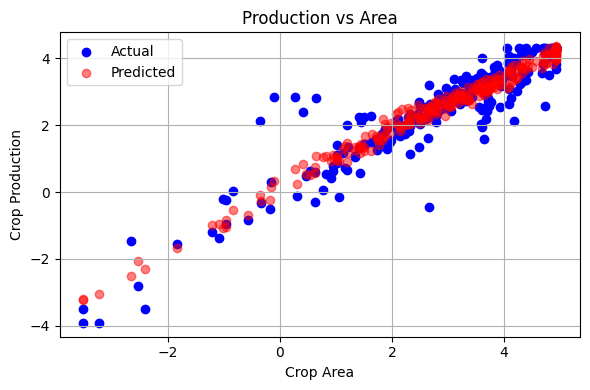

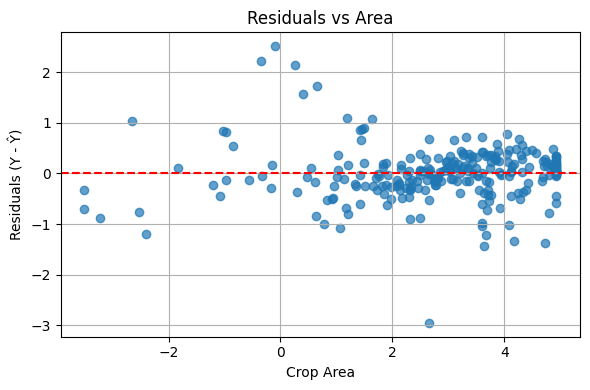

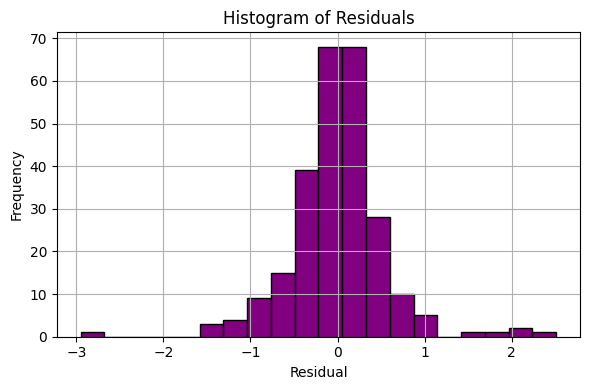

Sum of residuals: -0.000000


In [35]:
import torch
import matplotlib.pyplot as plt

# Assuming you already have X, Y, model
with torch.no_grad():
    Y_pred = model(X)
    residuals = (Y - Y_pred).squeeze()
    crop_area = X[:, 0].squeeze()  # assuming crop area is the first feature
    production = Y.squeeze()

# --- Plot 1: Crop production vs crop area ---
plt.figure(figsize=(6, 4))
plt.scatter(crop_area, production, color='blue', label='Actual')
plt.scatter(crop_area, Y_pred.squeeze(), color='red', alpha=0.5, label='Predicted')
plt.xlabel('Crop Area')
plt.ylabel('Crop Production')
plt.title('Production vs Area')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Residuals vs crop area ---
plt.figure(figsize=(6, 4))
plt.scatter(crop_area, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Crop Area')
plt.ylabel('Residuals (Y - Ŷ)')
plt.title('Residuals vs Area')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: Histogram of residuals ---
plt.figure(figsize=(6, 4))
plt.hist(residuals.numpy(), bins=20, color='purple', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Residual sum check ---
res_sum = residuals.sum().item()
print(f"Sum of residuals: {res_sum:.6f}")  # should be very close to zero (e.g., < 1e-6)


In [36]:
#OUtlier Observation
def compute_dfbetas(model, X, Y):
    n, p = X.shape
    X_aug = torch.cat([torch.ones(n, 1), X], dim=1)
    X_t = X_aug.T

    beta_full = torch.linalg.inv(X_t @ X_aug) @ X_t @ Y
    dfbetas = []

    for i in range(n):
        # Leave one out
        mask = torch.ones(n, dtype=torch.bool)
        mask[i] = False
        X_i = X[mask]
        Y_i = Y[mask]

        X_aug_i = torch.cat([torch.ones(X_i.shape[0], 1), X_i], dim=1)
        beta_i = torch.linalg.inv(X_aug_i.T @ X_aug_i) @ X_aug_i.T @ Y_i

        dfbeta_i = beta_full - beta_i
        dfbetas.append(dfbeta_i.unsqueeze(0))

    dfbetas = torch.cat(dfbetas, dim=0)  # shape: (n, p + 1)
    return dfbetas

dfbetas = compute_dfbetas(model, X, Y)
dfbeta_magnitudes = dfbetas.abs()

# Set a reasonable threshold for influence (say 2 / sqrt(n))
threshold = 2 / torch.sqrt(torch.tensor(float(X.shape[0])))
influential_obs = torch.any(dfbeta_magnitudes > threshold, dim=1)

print(f"Number of influential observations (DFBeta > {threshold:.4f}): {influential_obs.sum().item()}")
print(f"Indices of influential observations: {torch.where(influential_obs)[0].tolist()}")


Number of influential observations (DFBeta > 0.1252): 5
Indices of influential observations: [147, 164, 165, 231, 233]


In [37]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_copy is your original pandas DataFrame
X_vif = pd.DataFrame(X_copy.to_numpy(), columns=X_copy.columns)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


                       Feature         VIF
0             area1000hectares   37.654385
1    irrigatedarea1000hectares    3.489212
2  unirrigatedarea1000hectares   44.791368
3    nitrogenconsumptiontonnes  553.232938
4   phosphateconsumptiontonnes  687.887384
5      potashconsumptiontonnes   71.575617
6               total_rainfall   55.672909
7             average_rainfall   63.229028
8  salinity_alkalinity_percent    2.148731


In [38]:
y_hat = model(X)
residuals = Y - y_hat
std_resid = torch.std(residuals)
mean_resid = torch.mean(residuals)

outlier_mask = (residuals - mean_resid).abs() > 2 * std_resid
outlier_indices = torch.where(outlier_mask)[0]

print(f"Number of outliers: {outlier_indices.shape[0]}")
print(f"Outlier indices: {outlier_indices.tolist()}")


Number of outliers: 11
Outlier indices: [24, 69, 71, 105, 106, 147, 162, 163, 164, 165, 166]


In [39]:
farmer_input_indices = [X_copy.columns.get_loc(col) for col in [
    "area1000hectares",
    'irrigatedarea1000hectares',
    'unirrigatedarea1000hectares',
    'nitrogenconsumptiontonnes',
    'phosphateconsumptiontonnes',
    'potashconsumptiontonnes'
]]

weights = model.weights.detach().numpy()
rts_sum = sum(weights[i] for i in farmer_input_indices)

print(f"Sum of alpha (RTS) for farmer-controlled inputs: {rts_sum:.4f}")


Sum of alpha (RTS) for farmer-controlled inputs: 0.8596


erfect! You’ve computed:

    Sum of α (RTS) for farmer-controlled inputs: 0.8596

✅ Interpretation:

Since
α1+α2+⋯+α6=0.8596<1
α1​+α2​+⋯+α6​=0.8596<1

this implies:

    🧠 Decreasing Returns to Scale (DRS)
    If all farmer-controlled inputs are increased by 1%, the crop production increases by only ~0.86% — less than proportionally.

🧪 Hypothesis Test

Let’s formalize this conclusion:
Null Hypothesis (H₀):

Farmer-controlled inputs exhibit constant returns to scale
α1+α2+⋯+α6=1
α1​+α2​+⋯+α6​=1
Alternative Hypothesis (H₁):

Returns to scale are not constant
α1+α2+⋯+α6≠1
α1​+α2​+⋯+α6​=1